# Simulations - 1 

In [1]:
library(repr)
options(repr.plot.width=7, repr.plot.height=5, repr.plot.res = 120, repr.plot.quality = 30)
options(jupyter.plot_mimetypes = 'image/png')

In [2]:
setwd("~/yandexDisk/DIPLOMA/CODE/src/")
source("./simulations.functions.R", echo=FALSE)

Loading required package: lattice
Loading required package: ggplot2
Loading required package: MASS
Loading required package: MatchIt
Loading required package: nnet
Loading required package: numDeriv
CBPS: Covariate Balancing Propensity Score
Version: 0.10
Authors: Christian Fong <christianfong@stanford.edu>, Marc Ratkovic <ratkovic@princeton.edu>, Chad Hazlett <chazlett@ucla.edu>, Kosuke Imai <kimai@princeton.edu>

Loading required package: SparseM

Attaching package: ‘SparseM’

The following object is masked from ‘package:base’:

    backsolve

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel


In [3]:
# Defining control execution constants 
train.data.sample.sizes <- c(50, 100, 200, 400, 800)
test.data.sample.size <- 10000
number.of.covariates = 30
sample.size <-  200
offsets = seq(0.2, 1, length = 10)
control.offset = min(offsets) / 2
lambdas = seq(0,  10,  length=12)

registerDoParallel(cores = 4)
number.of.simulations <- 3

In [453]:
# prepare train data
train <- GetSimulationData(sample.size, number.of.covariates)
# prepare test data
test <- GetSimulationData(test.data.sample.size, number.of.covariates)

In [444]:
params.gen.sa <- OptimizeParamsOfPolicyFunction(train, 0.1, PolicyFunLinearKernel, 0.1,  
                                         list("obj.func" = ObjectiveFunction))
# params <- OptimizeParamsOfPolicyFunction(tune.obs.data, offset, policy.function, lambda, opt.hyperparams)

It: 1, obj value: 4041.846002
.............It: 1, obj value: 4041.799838
.It: 49, obj value: 3964.415128
.
It: 80, obj value: 3964.415114
.
It: 111, obj value: 3964.4151
.
It: 142, obj value: 3964.415086
.
It: 173, obj value: 3964.415072
.
It: 204, obj value: 3964.415058
It: 226, obj value: 3939.385558
It: 229, obj value: 3609.957941
.
It: 260, obj value: 3609.905454
....
It: 384, obj value: 3606.474717
.
It: 415, obj value: 3606.458445
...
It: 508, obj value: 3606.45841
.
It: 539, obj value: 3606.458379
............It: 919, obj value: 3522.410754
......................................................................................................................

In [441]:
params.gen.sa[params.gen.sa > 0]

[1] 16.890325975  0.246774259  0.132791140  0.128287825  0.021034687
 [6]  0.001241316  0.003013753  0.025391189  0.029508463  0.023734225
[11]  0.020132023  0.023007205  0.002534774 15.170700939  0.010339733
[16]  0.006191326  0.027418049  0.022484948

In [ ]:
opt.params.dca <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda)

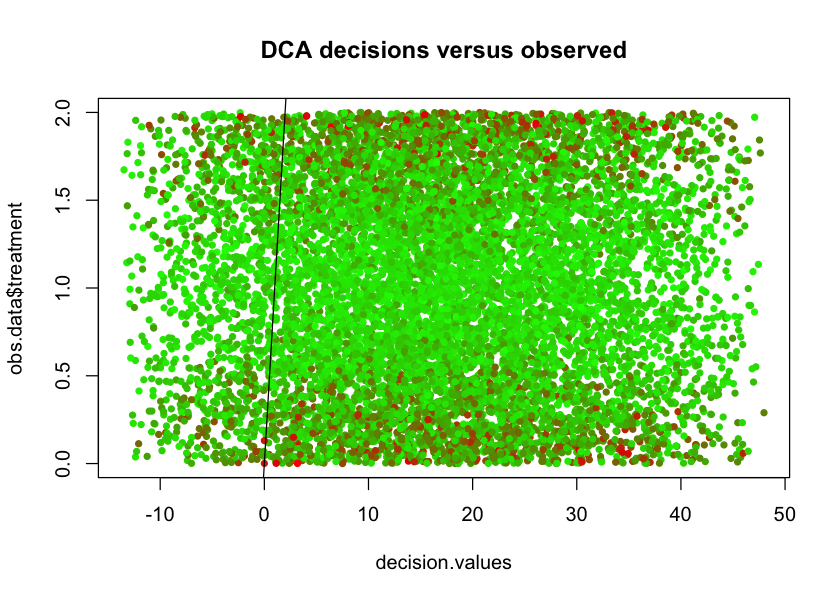

In [442]:
PlotDecsionsVersusObserved(test, PolicyFunLinearKernel, params.gen.sa)

In [449]:
# Test DCA on nonshifted reward 
global.result <- list()
for (offset in  offsets) {
  print(paste("Optimization offset: ", offset))
  result <- foreach (lambda = lambdas) %dopar% {
    folds <- createFolds(train$treatment)
    dtr.values.on.folds.dca <- GetDtrValuesOnFolds(folds, train, offset, control.offset, 
                                                   PolicyFunLinearKernel, lambda)
    opt.params.dca <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda)
    dtr.value.on.test.dca <- ValueFunction(opt.params.dca, test, offset, PolicyFunLinearKernel)
#     dtr.values.on.folds.gen.sa <- GetDtrValuesOnFolds(folds, train, offset, control.offset, 
#                                                PolicyFunLinearKernel, lambda)
    return (list("offset"=offset, "lambda"=lambda,
                 # "value.function.gen.sa"=mean.dtr.value.gen.sa,
                 "dtr.values.on.folds.dca"=dtr.values.on.folds.dca,
                 "dtr.value.on.test.dca"=dtr.value.on.test.dca))
  }
  global.result <- c(global.result, result)
}

[1] "Optimization offset:  0.2"
[1] "Optimization offset:  0.288888888888889"
[1] "Optimization offset:  0.377777777777778"
[1] "Optimization offset:  0.466666666666667"
[1] "Optimization offset:  0.555555555555556"
[1] "Optimization offset:  0.644444444444444"
[1] "Optimization offset:  0.733333333333333"
[1] "Optimization offset:  0.822222222222222"
[1] "Optimization offset:  0.911111111111111"
[1] "Optimization offset:  1"


Выбранные по кроссвалидации параметры:

In [408]:
# create result matrix with statistics for every params combination tested
result.to.plot <- as.data.frame(t(sapply(global.result, cbind)))
colnames(result.to.plot)  <- names(global.result[[1]])

result.to.plot$sd <- sapply(result.to.plot$dtr.values.on.folds.dca, sd)
result.to.plot$mean.folds.dtr.value.dca <- sapply(
   result.to.plot$dtr.values.on.folds.dca, mean)

for (column in c("offset", "lambda", "dtr.value.on.test.dca")) {
    result.to.plot[column] <- as.numeric(unlist(result.to.plot[column]))
}
result.to.plot$lambda  <- as.factor(result.to.plot$lambda)

pars.dca <-  result.to.plot[ which.max(result.to.plot$mean.folds.dtr.value.dca),  ]
best.offset.dca <- as.numeric(pars.dca$offset)
best.lambda.dca <- as.numeric(as.character(pars.dca$lambda))
cat("Choosen params by CV:")
pars.dca

Choosen params by CV:

,offset,lambda,dtr.values.on.folds.dca,dtr.value.on.test.dca,sd,mean.folds.dtr.value.dca
102,0.9111111,4.54545454545454,"0.0000000, 13.0036987, 1.4181828, 1.3249271, 2.9172387, -0.8698931, 1.6158664, 2.5847853, 3.0162351, -2.7351647",-12.6172,4.194962,2.227588


In [411]:
opt.params.dca <- OptimizeParamsOfPolicyFunction(train, best.offset.dca, PolicyFunLinearKernel, best.lambda.dca)
dtr.value.on.test.dca <- ValueFunction(opt.params.dca, test, best.offset.dca, PolicyFunLinearKernel)
cat("CV choosen DTR value using all train: ", dtr.value.on.test.dca)

Iteration 0 
Iteration 1 
CV choosen DTR value using all train:  -12.6172

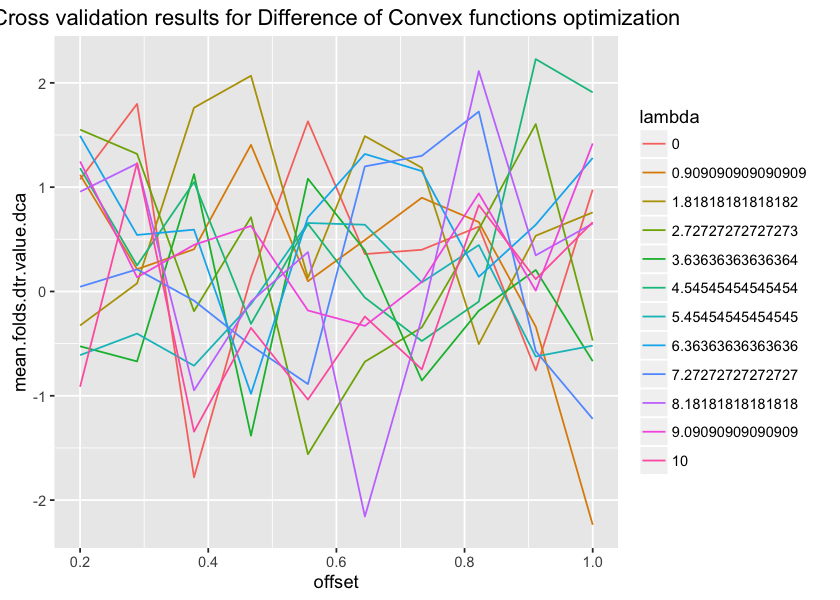

In [427]:
ggplot(result.to.plot, aes(x = offset, y = mean.folds.dtr.value.dca, colour = lambda)) +
#   geom_errorbar(aes(ymin=value.function.dca-sd, 
#                       ymax=value.function.dca+sd), width=0.01) +
  geom_line() +
  ggtitle("Cross validation results for Difference of Convex functions optimization")

In [443]:
opt.params.dca[opt.params.dca  > 0.00001]

X.Intercept.           V1           V2           V3           V5           V6 
 0.968835341  0.034340902  0.022484325  0.080474921  0.002864248  0.050443414 
          V7          V13          V14          V17          V19          V21 
 0.260299536  0.001816114  0.096401361  0.010469789  0.140881636  0.003887344 
         V28          V30 
 0.047627985  0.038415263

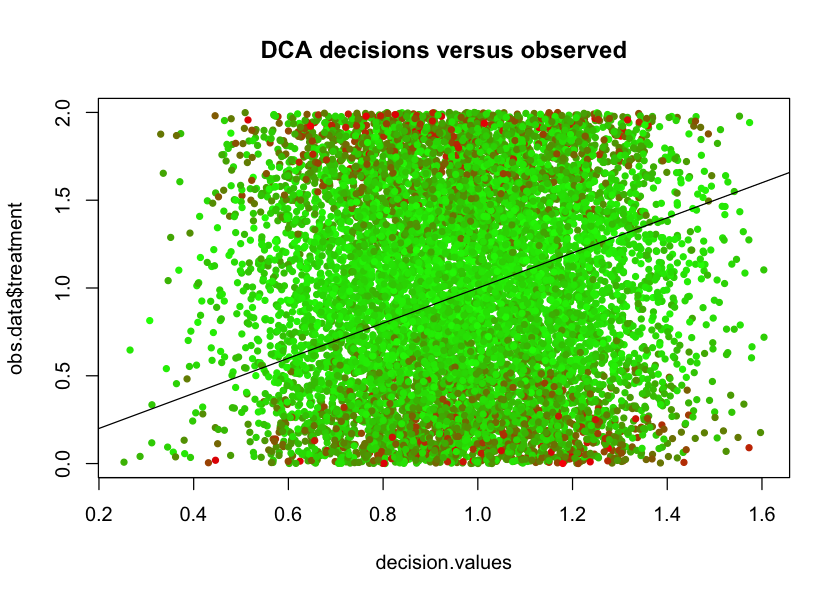

In [429]:
PlotDecsionsVersusObserved(test, PolicyFunLinearKernel, opt.params.dca)

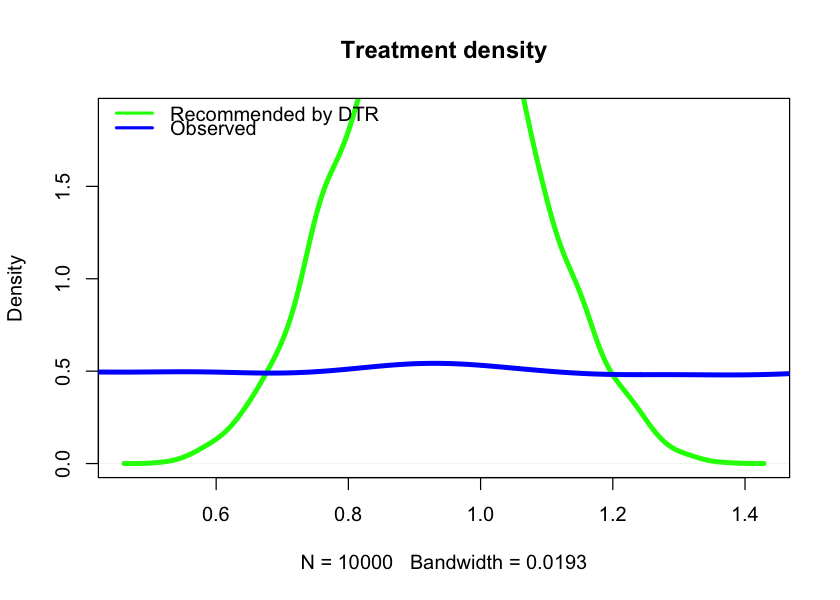

In [430]:
plot(density(decision.values), col="green", lwd=4,  ylim=c(0, 1.9),
     main = "Treatment density")
lines(density(test.treatment), col="blue", lwd=4)
legend("topleft", c("Recommended by DTR", "Observed"),
       lwd=c(2.5,2.5),col=c("green","blue"), bty = "n")

In [431]:
# get best possible combinations of lambda and offset based on test performance
best.index <- which.max(result.to.plot$dtr.value.on.test.dca)
cat("Best possible result:")
result.to.plot[best.index, ]

best.lambda.on.test <- result.to.plot[best.index, "lambda"]
best.offset.on.test <- result.to.plot[best.index, "offset"]

Best possible result:

,offset,lambda,dtr.values.on.folds.dca,dtr.value.on.test.dca,sd,mean.folds.dtr.value.dca
6,0.2,4.54545454545454,"0.3595162, -2.1026798, 0.0000000, 0.0000000, 1.9902205, 1.8695794, 5.4686287, 2.9714395, -1.0753593, 2.3388572",1.443837,2.195883,1.18202


ERROR: Error in OptimizeParamsOfPolicyFunction(train.treatment, train.covariates, : unused arguments (PolicyFunLinearKernel, best.lambda.on.test)


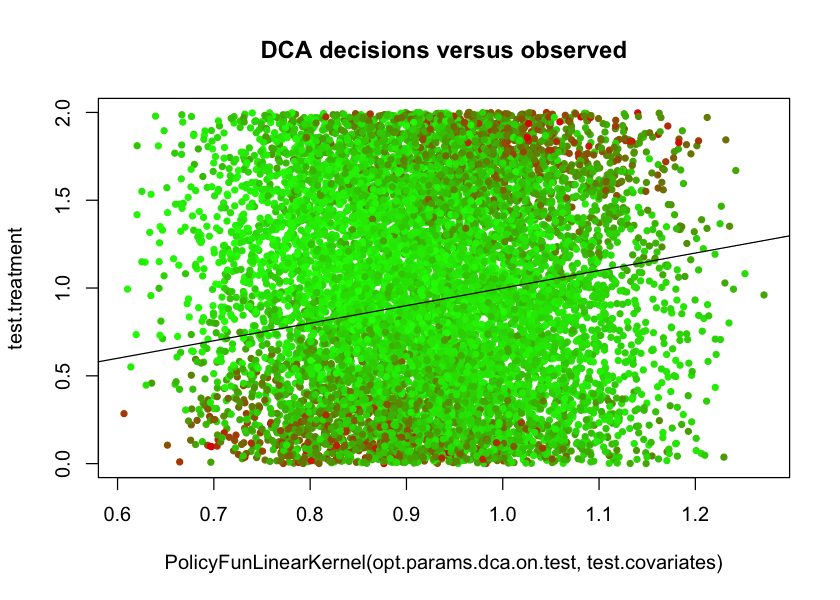

In [432]:
# Plot best decision possible (on test data)
opt.params.dca.on.test <- OptimizeParamsOfPolicyFunction(train.treatment,
    train.covariates, train.prop.scores, train.reward, best.offset.on.test,
    PolicyFunLinearKernel, best.lambda.on.test)

rewards.scaled.0.1 <- (test.reward - min(test.reward) ) /
                      (max(test.reward) - min(test.reward))
plot(PolicyFunLinearKernel(opt.params.dca.on.test, test.covariates),
     test.treatment,
     col=rgb(1 - rewards.scaled.0.1, rewards.scaled.0.1, 0),
     pch=20, main="DCA decisions versus observed")
abline(0, 1)

# Проблемы

1. Почему обращается value function в 0 на тестовой выборке с ростом параметра сдвига ?

    > Потому что мы оцениваем сравниваем между собой ценности DTR на заданном фиксированном и малом отступе $\varphi = 0.005$ Ноль получается потому что в радиус этого отступа относительно наблюденного treatment не попадет наш предсказанный treatment ни для какого из предсказаний. Все, что показано ниже сделано для увеличенного в 10 раз $\varphi = 0.005 \to \varphi = 0.05$ 

2. Попробовать сдвигать обратно reward перед вычислением value function ?
    > Попробовал оптимизировать только по сдвинутым значениям value function, а оценивать в процессе CV  с помощью сырых reward. Результат интересный. В двух словах, идеальный value function на тестовых данных держится в районе 1.5, что ближе, чем полученное ранее $\sim 40$. Правда я еще прикрутил дополнительно CBPS в two step mode.    

3. Попробовать квадрат / логарифм / : неотрицательность дозы
     > Учитывая, что в отрицательную область предсказания перестали уходить, это не делал

4. Попробовать lambda=0

    > При кросс валидации видно, что это далеко не лучший способ, дает хуже результаты, чем при каком-нибудь другом $\lambda$. 

5. Попробовать быструю оптимизацию которая умеет много параметров вместо annealing

    > ** Пока не успел **

6. Написать деревьям, если не ответят - на mail list R help 

    > Написал деревьям, код MIDAs у нас есть. Они его не выложили еще в публичный доступ, потому что в процессе допиливания кода на fortran, который под капотом у этого MIDAs

7. Почему при $\lambda \to \infty$ мы получаем наилучшее value func  в  симуляции?

    > Причинной этому является то, что у нас очень интересно расположены точки в симуляции. При крайних значениях treatment (вблизи 0 и вблизи 2.0) мы имеем большинство плохих резульататов. Поэтому  linear DTR  стремится стать вообще горизонтальной линией $y=1$. 

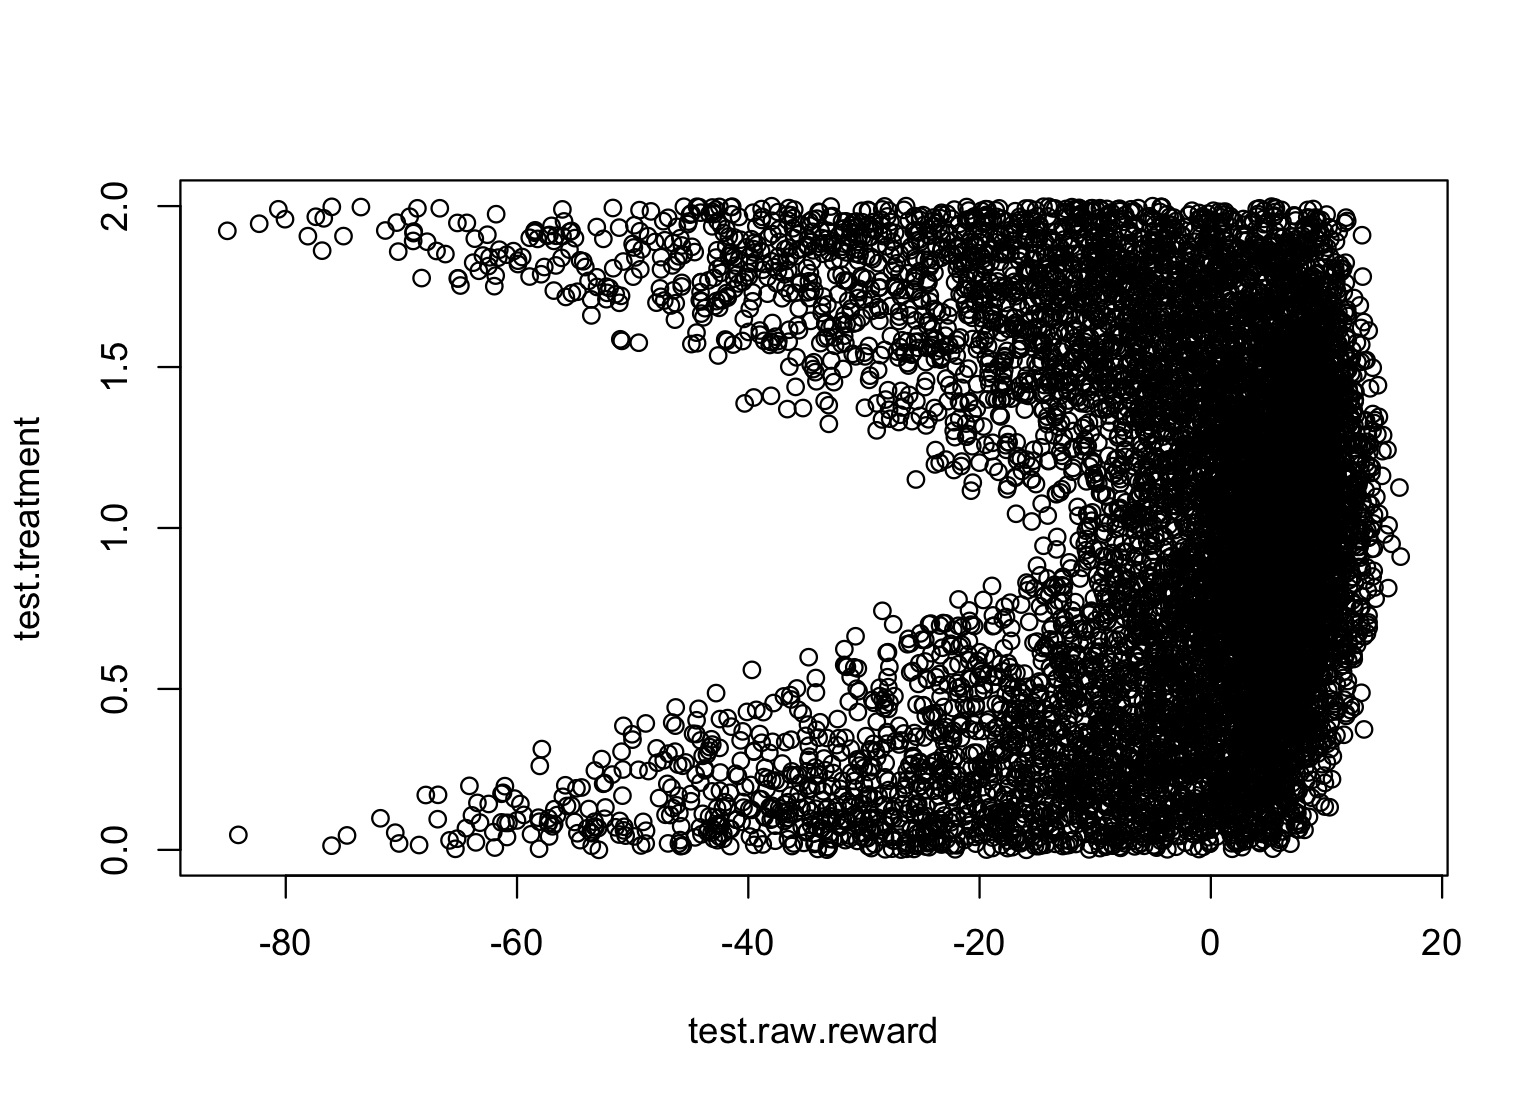

In [245]:
plot(test.raw.reward, test.treatment)

# Вопросы

### Даже если допустить, что мы знаем идеальное решение (т.е. заранее знаем какие коэффициенты должны быть в линейной модели), то все равно не получается value function настолько большой, как у Kosorok). Иллюстрация:

Ideal DTR value function =  6.250823

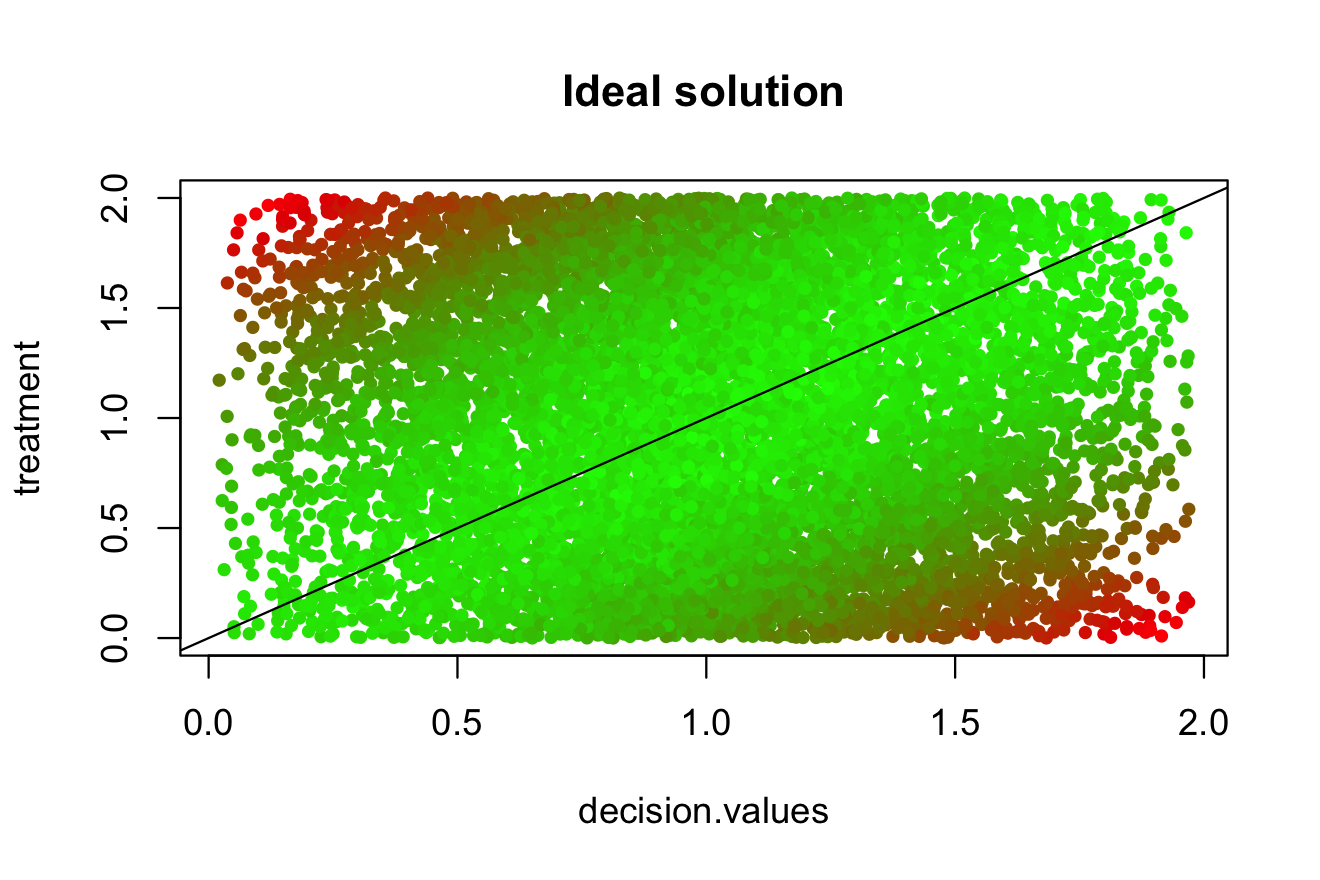

In [311]:
opt.decision <- c(1, 0.5, 0.5 , rep(0, length(opt.params.dca) -3 ))
names(opt.decision) <- names(opt.params.dca)
plot.decsions.versus.observed(test.treatment, test.covariates, test.reward, PolicyFunLinearKernel, opt.decision, 
                             title="Ideal solution")
dtr.value.on.test.ideal <- ValueFunction(opt.decision, test.treatment,
    test.covariates,  test.prop.scores,  test.raw.reward,
    offset, PolicyFunLinearKernel)
cat("Ideal DTR value function = ", dtr.value.on.test.ideal)

**<font color='red'> И даже при таком запуске, невозможно получить большое значение средней суррогатной функции! </font>** 

Как у него получилось это значение $> 7$, для меня пока загадка.

In [351]:
results <- c()
for (i in seq(0, 10)) {
    test.data <- GetSimulationData(test.data.sample.size, number.of.covariates)
    dtr.value.on.test.ideal <-  ValueFunction(params = opt.decision, obs.data = test.data, 
                  offset = control.offset, policy.function = PolicyFunLinearKernel)
    results <- c(results, dtr.value.on.test.ideal)
}

cat("Mean ideal DTR value = ", mean(results)) 

Mean ideal DTR value =  13.12268

### Следующий вопрос

In [350]:
test.data.list <- GetSimulationData(test.data.sample.size, number.of.covariates)
ValueFunction(params = opt.decision, obs.data = test.data.list, 
              offset = control.offset, policy.function = PolicyFunLinearKernel)

[1] 12.29184